# Data Cleaning for Higgs Boson Dataset

## Import packages

In [1]:
from pyspark.sql.functions import when, col, lit
from pyspark.sql import SparkSession
from pyspark import SparkContext
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os

## Create SparkContext and SparkSession

In [2]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 00:16:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 00:16:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/12 00:16:11 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
RAW_DATA_FOLDER = "raw_data"
STAGING_DATA_FOLDER = "staging_data"
FIGURES_FOLDER = "figures"

## Read CSV, transform and load to Dataframe

In [4]:
rdd = sc.textFile(os.path.join(RAW_DATA_FOLDER, "HIGGS.csv"))
rdd = rdd.map(
    lambda row: [
        int(float(v)) if i == 0 else float(v) for i, v in enumerate(row.split(","))
    ]
)
df = rdd.toDF(
    schema=[
        "signal",
        "lepton pT",
        "lepton eta",
        "lepton phi",
        "missing energy magnitude",
        "missing energy phi",
        "jet 1 pt",
        "jet 1 eta",
        "jet 1 phi",
        "jet 1 b-tag",
        "jet 2 pt",
        "jet 2 eta",
        "jet 2 phi",
        "jet 2 b-tag",
        "jet 3 pt",
        "jet 3 eta",
        "jet 3 phi",
        "jet 3 b-tag",
        "jet 4 pt",
        "jet 4 eta",
        "jet 4 phi",
        "jet 4 b-tag",
        "m_jj",
        "m_jjj",
        "m_lv",
        "m_jlv",
        "m_bb",
        "m_wbb",
        "m_wwbb",
    ]
)

## Clip Outliers

In [5]:
bounds = {
    "lepton pT": 4.0,
    "missing energy magnitude": 4.0,
    "jet 1 pt": 4.0,
    "jet 2 pt": 4.0,
    "jet 3 pt": 4.0,
    "jet 4 pt": 4.0,
    "m_jj": 7.0,
    "m_jjj": 4.0,
    "m_lv": 2.5,
    "m_jlv": 4.0,
    "m_bb": 4.5,
    "m_wwbb": 3.0,
    "m_wbb": 3.5,
}
# Apply clipping
for column in df.columns:
    upper_bound = bounds.get(column)
    if upper_bound is not None:
        df = df.withColumn(
            column,
            when(col(column) > lit(upper_bound), lit(upper_bound)).otherwise(
                col(column)
            ),
        )

## Save Cleaned Data to Staging Data

In [9]:
df.coalesce(1).write.format("csv").option("header", "false").mode("overwrite").save(
    os.path.join(STAGING_DATA_FOLDER, "clean")
)

In [12]:
files = os.listdir(os.path.join(STAGING_DATA_FOLDER, "clean"))
csv_file = next((file for file in files if file.endswith(".csv")), None)
os.rename(
    os.path.join(STAGING_DATA_FOLDER, os.path.join("clean", csv_file)),
    os.path.join(STAGING_DATA_FOLDER, "clean.csv"),
)
shutil.rmtree(os.path.join(STAGING_DATA_FOLDER, "clean"))

## DataFrame Samples

In [14]:
df_sample = df.sample(fraction=0.000001, seed=42)
df_sample.toPandas().to_csv(
    os.path.join(FIGURES_FOLDER, "samples_after_cleaning.csv"), index=False
)
df_sample.show(truncate=False)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


+------+-------------------+--------------------+---------------------+------------------------+--------------------+-------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+-----------------+-------------------+-------------------+--------------------+-----------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|signal|lepton pT          |lepton eta          |lepton phi           |missing energy magnitude|missing energy phi  |jet 1 pt           |jet 1 eta           |jet 1 phi           |jet 1 b-tag       |jet 2 pt          |jet 2 eta           |jet 2 phi           |jet 2 b-tag      |jet 3 pt           |jet 3 eta          |jet 3 phi           |jet 3 b-tag      |jet 4 pt          |jet 4 eta           |jet 4 phi          |jet 4 b-tag     

## Basic Statistics of all columns

In [15]:
df_describe = df.describe()
df_describe.toPandas().to_csv(os.path.join(FIGURES_FOLDER, "stats_after_cleaning.csv"), index=False)
df_describe.show(truncate=False)

+-------+-------------------+------------------+-------------------+----------------------+------------------------+---------------------+-------------------+----------------------+-------------------+------------------+-------------------+----------------------+----------------------+------------------+-------------------+--------------------+--------------------+------------------+-------------------+---------------------+---------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|signal             |lepton pT         |lepton eta         |lepton phi            |missing energy magnitude|missing energy phi   |jet 1 pt           |jet 1 eta             |jet 1 phi          |jet 1 b-tag       |jet 2 pt           |jet 2 eta             |jet 2 phi             |jet 2 b-tag       |jet 3 pt           |jet 3 eta           |jet 3 phi           |jet 3 b-tag       |jet 4 p

## Feature Analysis

In [16]:
def plot_and_save_figure(data, colname, huename):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    _ = sns.kdeplot(data, x=colname, fill=True, ax=ax[0])
    _ = sns.kdeplot(data, x=colname, hue=huename, fill=True, ax=ax[1])
    fig.savefig(os.path.join(FIGURES_FOLDER, f"{colname}_after_cleaning.png"))

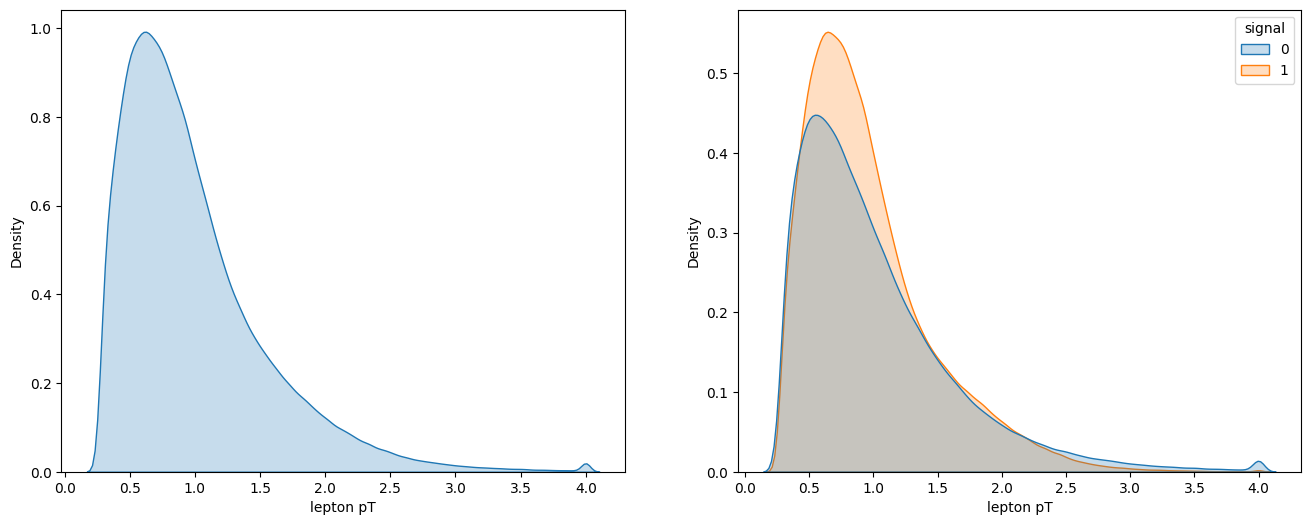

In [17]:
colname = "lepton pT"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

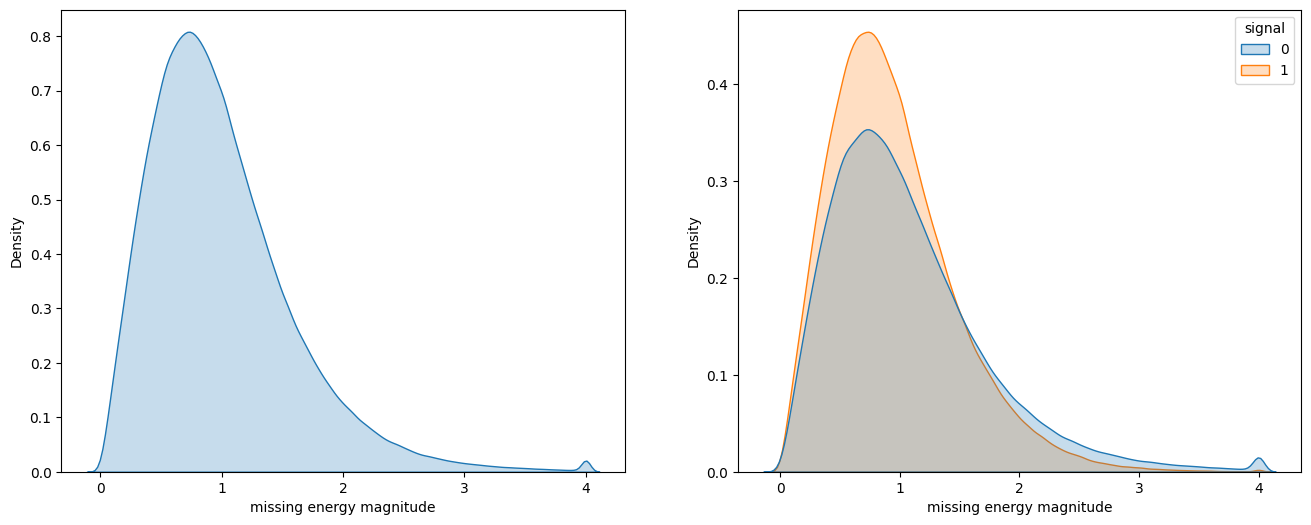

In [18]:
colname = "missing energy magnitude"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

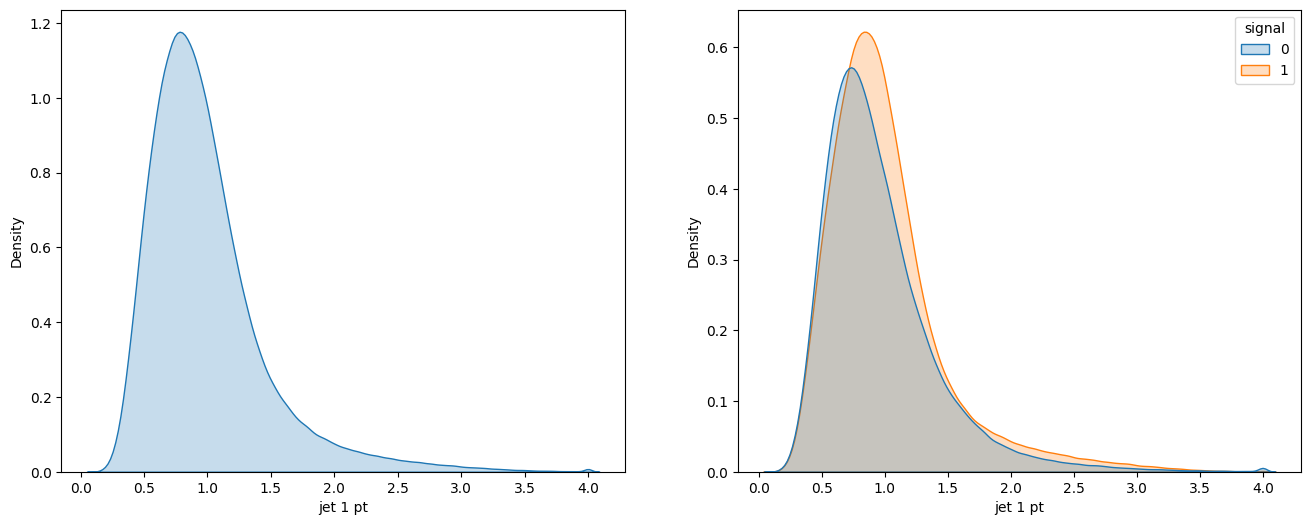

In [19]:
colname = "jet 1 pt"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

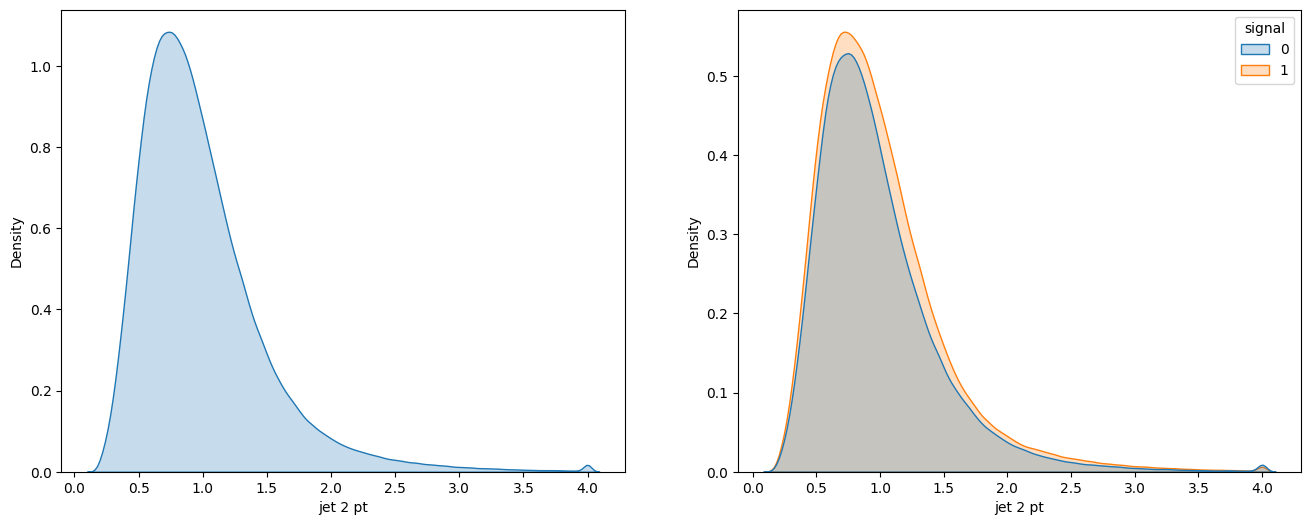

In [20]:
colname = "jet 2 pt"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

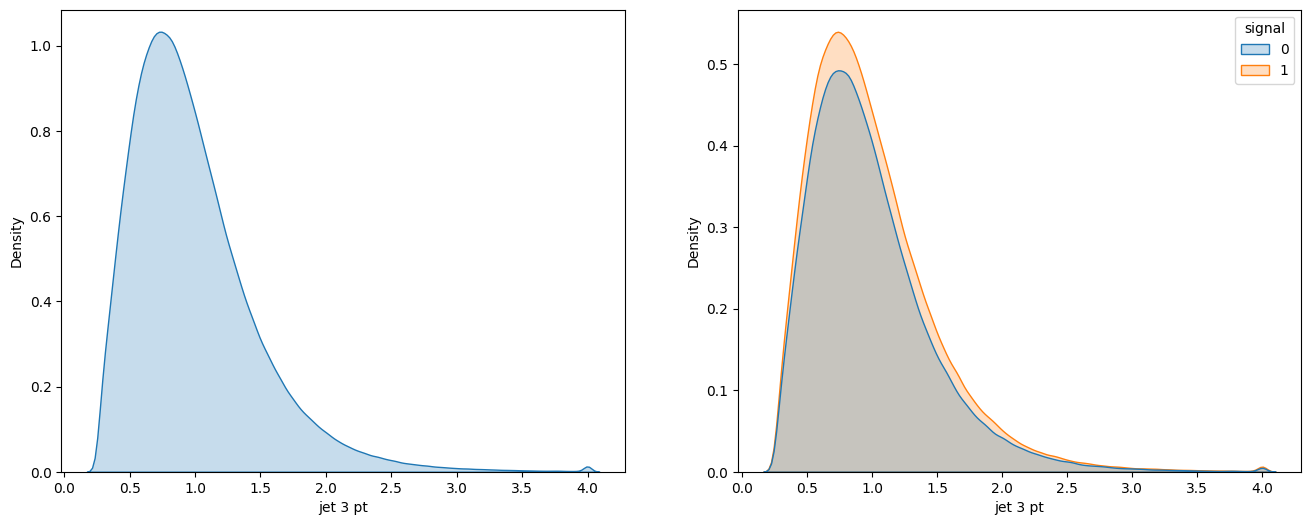

In [21]:
colname = "jet 3 pt"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

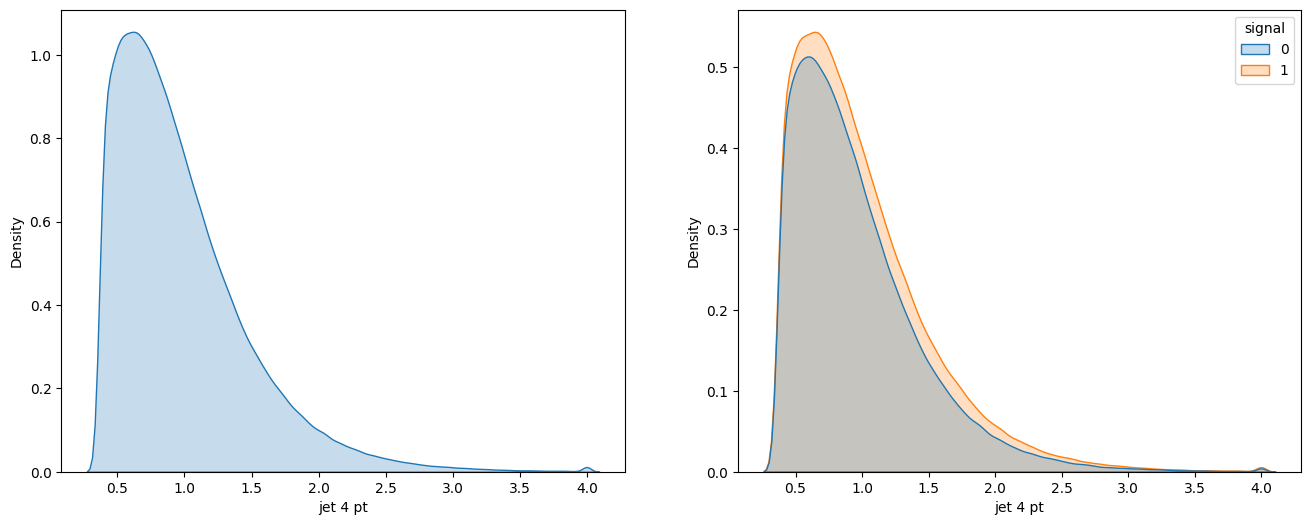

In [22]:
colname = "jet 4 pt"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

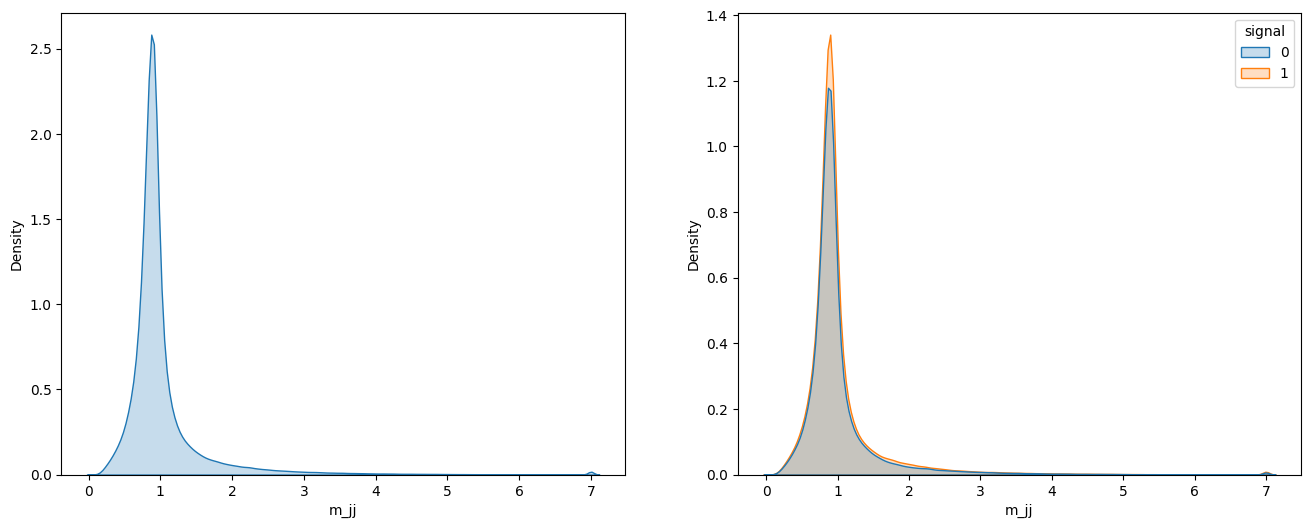

In [23]:
colname = "m_jj"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

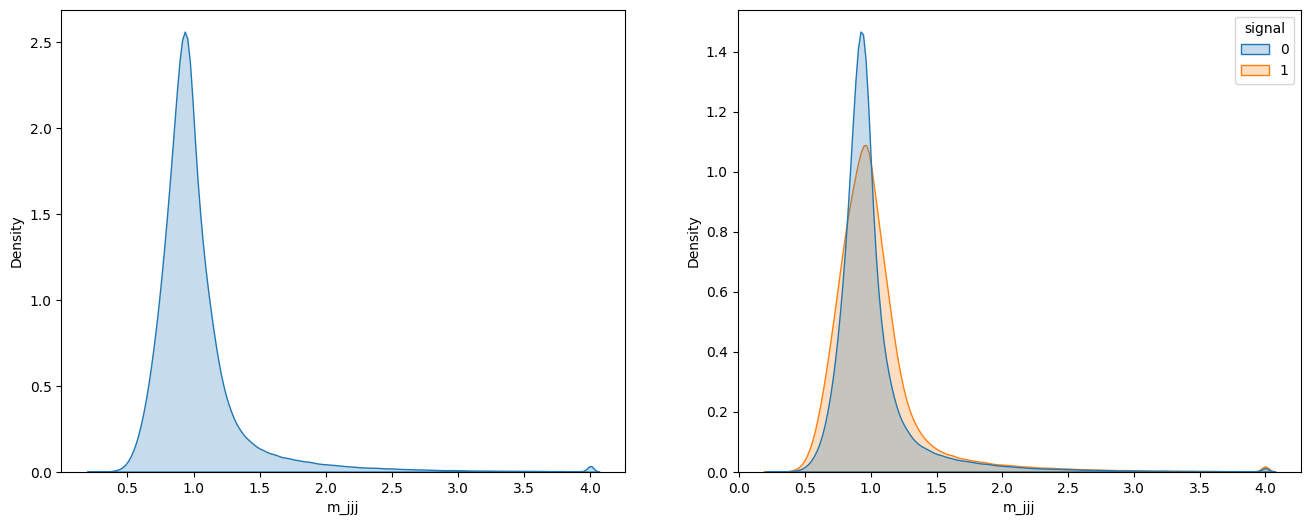

In [24]:
colname = "m_jjj"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

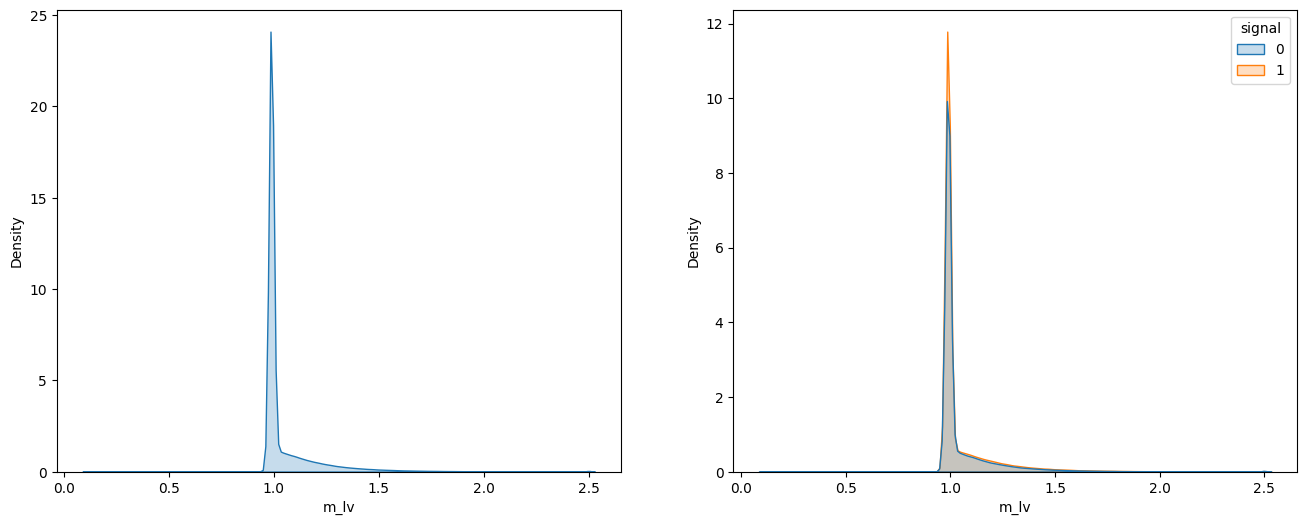

In [25]:
colname = "m_lv"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

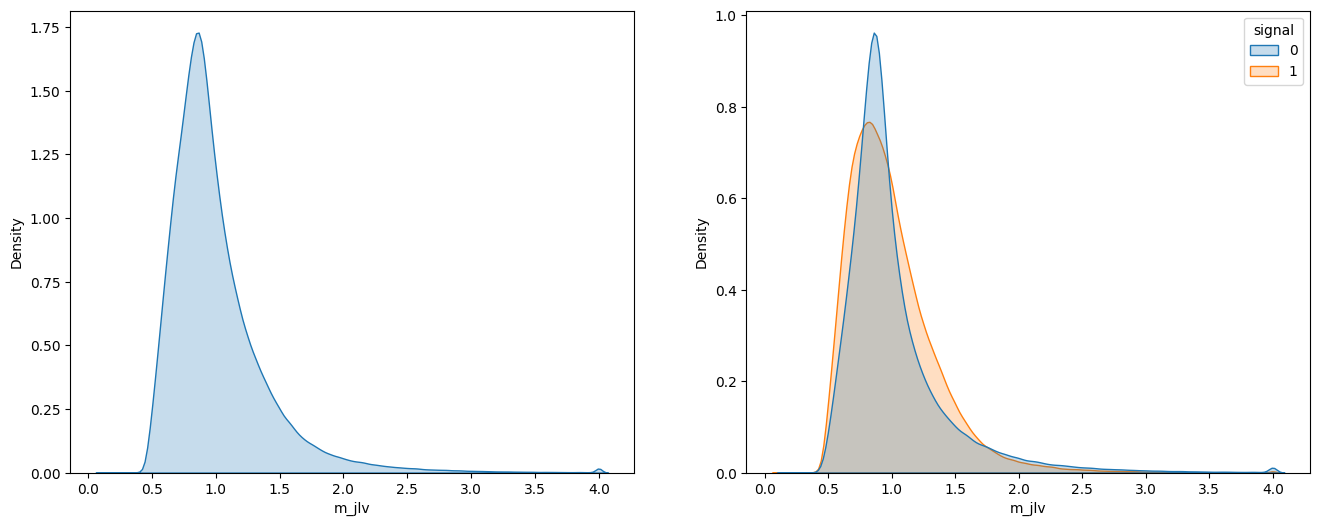

In [26]:
colname = "m_jlv"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

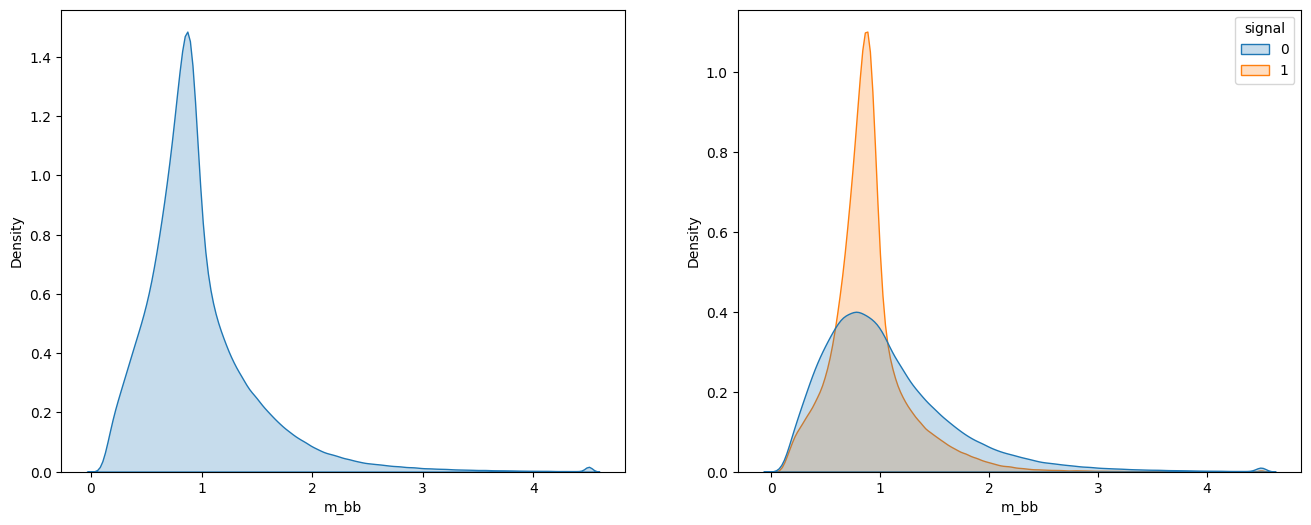

In [27]:
colname = "m_bb"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

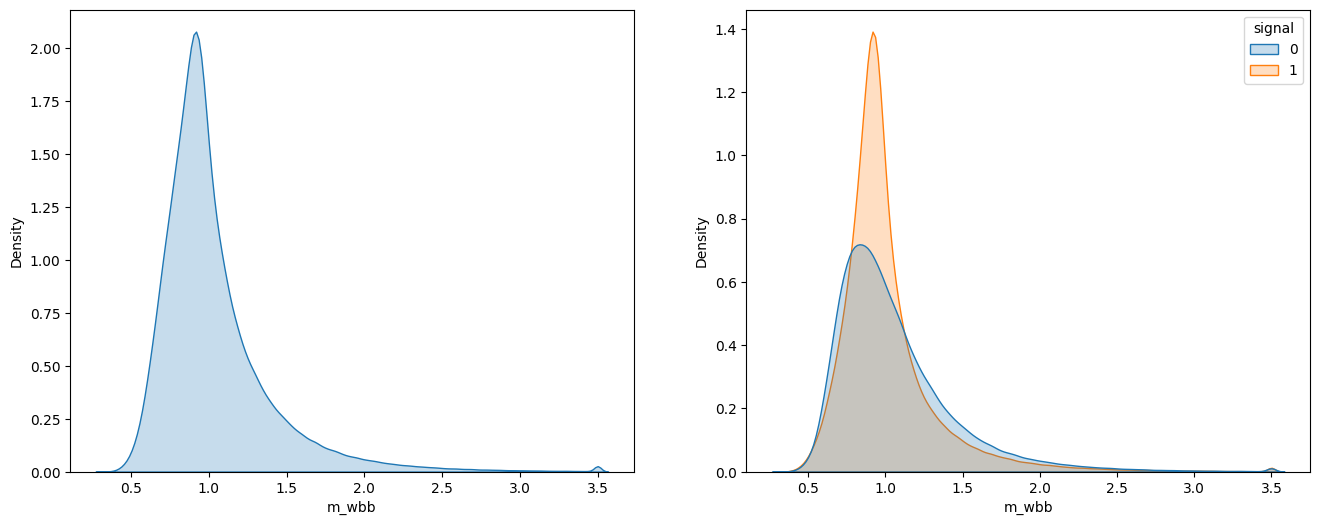

In [28]:
colname = "m_wbb"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")

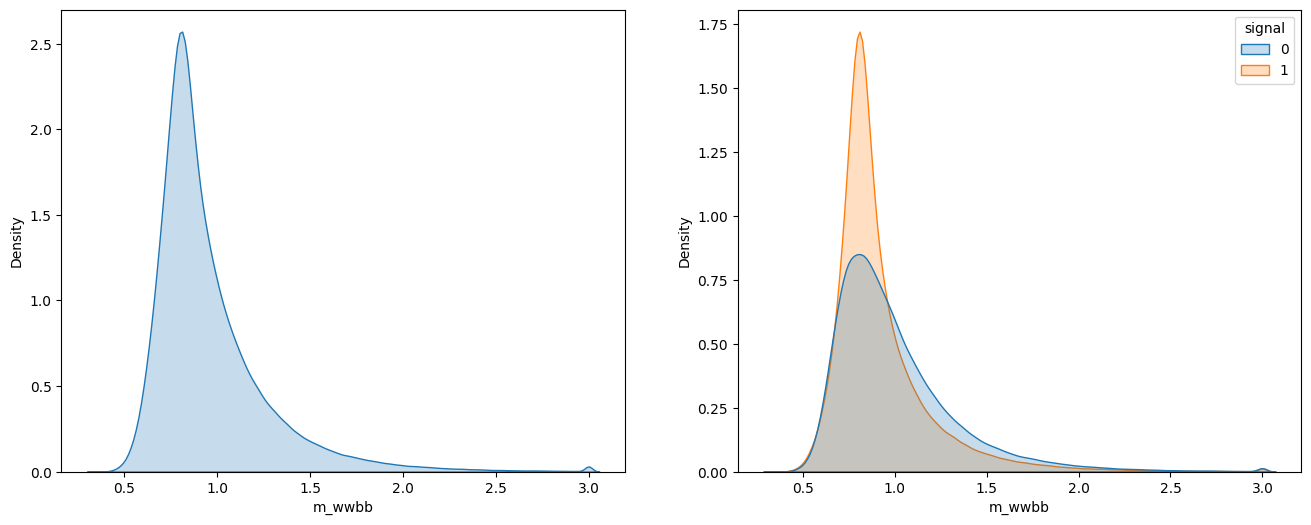

In [29]:
colname = "m_wwbb"
data = df.select(["signal", colname]).sample(fraction=0.1, seed=42).toPandas()
plot_and_save_figure(data, colname, "signal")